# First contact with the dataset

In [1]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

from termcolor import colored

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('winequality.csv', sep=';')

print('Loaded', len(data), 'samples')
data.head()

Loaded 6497 samples


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Getting dirty values

In [3]:
keys_list = list(data.keys())
def check_dirty(func, s):
    check = False
    for k in keys_list:
        counter = data[k].map(func).sum()
        if counter > 0:
            check = True
            print('\'',k, '\' field has', counter, s, 'values')
    if not check:
        print('There are no', s, 'values')

In [4]:
check_dirty(lambda x: type(x) is not float, 'NOT FLOAT') # this is not exactly dirty
print('\n')
check_dirty(lambda x: type(x) is str, 'STRING') # this is OK for 'type' field
print('\n')
check_dirty(lambda x: x is None, 'NONE')
print('\n')
check_dirty(lambda x: x is np.nan, 'NaN')

' type ' field has 6497 NOT FLOAT values
' alcohol ' field has 6497 NOT FLOAT values
' quality ' field has 6497 NOT FLOAT values


' type ' field has 6497 STRING values
' alcohol ' field has 6497 STRING values


There are no NONE values


There are no NaN values


In [5]:
data['quality'].dtype

dtype('int64')

In [19]:
(np.min(data['quality'].as_matrix()), np.max(data['quality'].as_matrix()))

(3, 9)

In [6]:
# NULL values have not been seen by lambda functions
check = False
for k in keys_list:
    counter = data[k].isnull().sum()
    if counter > 0:
        check = True
        print('\'',k, '\' field has', counter, 'NULL values')

if not check:
    print('There are no NULL values')

There are no NULL values


## Fixing dirty fields

In [7]:
try:
    data['type'] = data['type'].map(lambda x: 1 if x == 'White' else 0)
    print('\' type \' field is fixed')
except Exception as e:
    print('ERROR:', e)
    pass

' type ' field is fixed


In [8]:
try:
    data['alcohol'] = data['alcohol'].map(lambda x: float(x))
    print('\' alcohol \' field is fixed')
except Exception as e:
    print('ERROR:', e)
    pass

ERROR: could not convert string to float: '128.933.333.333.333'


In [9]:
def fix_alcohol_field(s):
    if s.count('.') > 1:
        return None
    else:
        return float(s)

In [10]:
try:
    data['alcohol'] = data['alcohol'].map(fix_alcohol_field)
    print('\' alcohol \' field is fixed')
except Exception as e:
    print('ERROR:', e)
    pass

' alcohol ' field is fixed


In [11]:
check_dirty(lambda x: type(x) is str, 'STRING')
check_dirty(lambda x: x is None, 'NONE')
print(data['alcohol'].isnull().sum(), 'NULL values in \' alcohol \' field')

data.head()

There are no STRING values
There are no NONE values
40 NULL values in ' alcohol ' field


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [12]:
data[data['alcohol'].isnull()].head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4315,1,6.7,0.41,0.24,5.4,0.035,33.0,115.0,0.99010,3.12,0.44,NaN,7
4319,1,6.7,0.41,0.24,5.4,0.035,33.0,115.0,0.99010,3.12,0.44,NaN,7
4323,1,8.4,0.27,0.30,2.2,0.037,36.0,129.0,0.99085,2.89,0.30,NaN,6
4341,1,7.4,0.27,0.52,15.7,0.054,36.0,139.0,0.99788,3.04,0.62,NaN,6
4353,1,7.4,0.16,0.30,1.4,0.064,34.0,166.0,0.99136,3.11,0.42,NaN,6


In [13]:
data = data.dropna() # samples with NULL values are removed

## Data normalization ~ N(0,1)

### All fields are normalized as gaussians with mean = 0 and variance = 1

### This normalization is just a linear transformation that does not change following analysis, like correlations

In [14]:
keys_output = ['quality'] # output fields
keys_input = list(set(keys_list) - set(keys_output)) # input fields

for k in keys_input:
    mean = data[k].mean()
    var = data[k].var()
    data[k] = data[k].map(lambda x: (x - mean)/var)

## Some graphics and numbers

<IPython.core.display.Javascript object>


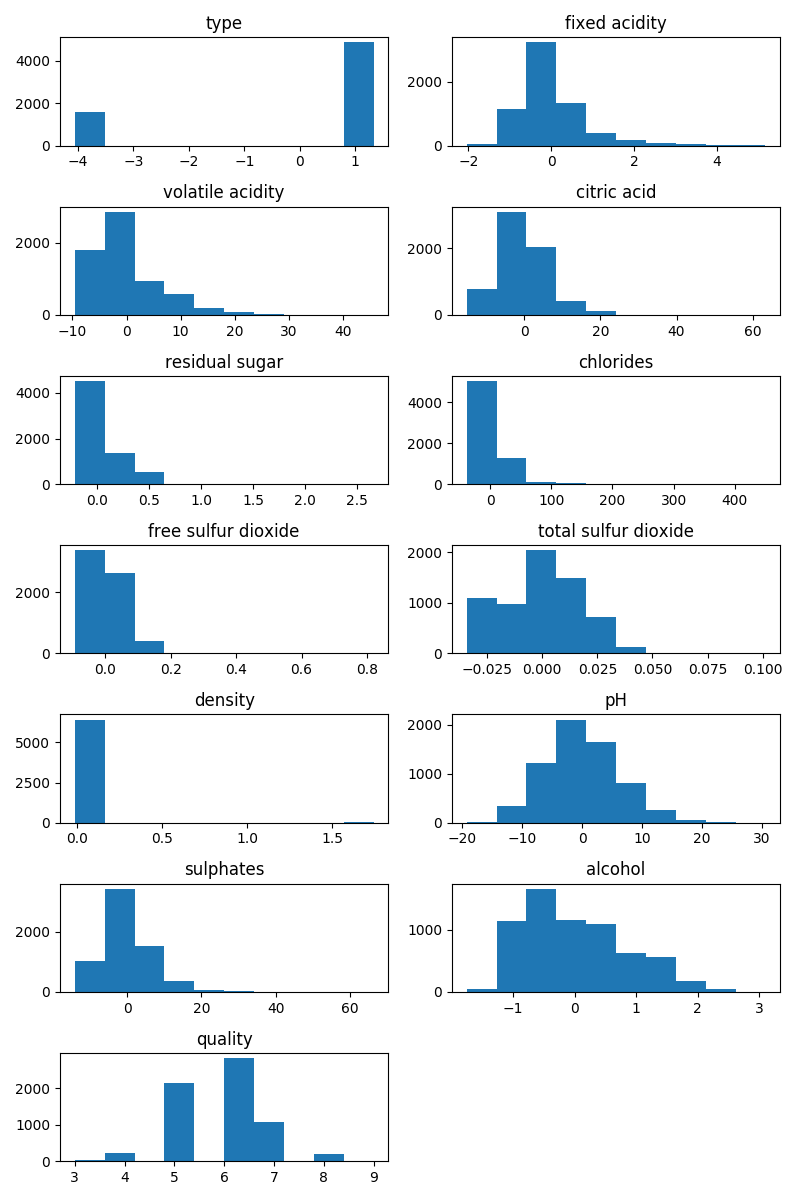

In [15]:
plt.figure(figsize=(8,12), num='Histograms')

for i,k in enumerate(keys_list):
    ax = plt.subplot2grid((7,2), (i//2,i%2))
    ax.set_title(k)
    ax.hist(data[k]);
plt.tight_layout()

<IPython.core.display.Javascript object>


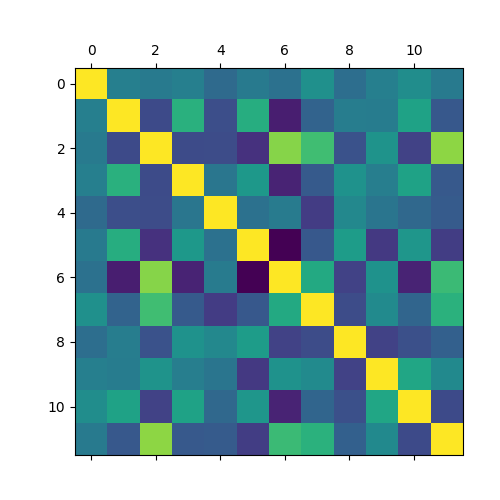

In [16]:
plt.figure(figsize=(5,5), num='Correlation matrix')
plt.matshow(data[keys_input].corr(), fignum='Correlation matrix');

In [17]:
print('Correlations coeficients with high values (above .7) in', colored('BLUE', 'blue'))
data[keys_input].corr().style.applymap(lambda x: 'color: ' + ('blue' if np.abs(x) > .7 else 'black'))

Correlations coeficients with high values (above .7) in BLUE


,density,chlorides,total sulfur dioxide,sulphates,alcohol,volatile acidity,type,residual sugar,pH,citric acid,fixed acidity,free sulfur dioxide
density,1,0.061558,0.031136,0.0630414,-0.0802638,0.0309432,-0.0372067,0.175994,-0.0529091,0.0577487,0.159592,0.0298778
chlorides,0.061558,1,-0.279826,0.396991,-0.255883,0.376801,-0.51217,-0.129404,0.0450367,0.0386759,0.297079,-0.194374
total sulfur dioxide,0.031136,-0.279826,1,-0.275119,-0.266148,-0.415214,0.700798,0.495998,-0.239278,0.195571,-0.328131,0.720979
sulphates,0.0630414,0.396991,-0.275119,1,-0.00448365,0.226266,-0.487805,-0.185948,0.191299,0.0562718,0.301531,-0.188002
alcohol,-0.0802638,-0.255883,-0.266148,-0.00448365,1,-0.0369159,0.0320015,-0.359799,0.121955,-0.00908656,-0.0936915,-0.180348
volatile acidity,0.0309432,0.376801,-0.415214,0.226266,-0.0369159,1,-0.652614,-0.19624,0.2614,-0.378046,0.218711,-0.35304
type,-0.0372067,-0.51217,0.700798,-0.487805,0.0320015,-0.652614,1,0.349328,-0.329607,0.187361,-0.486202,0.471215
residual sugar,0.175994,-0.129404,0.495998,-0.185948,-0.359799,-0.19624,0.349328,1,-0.266895,0.141384,-0.112389,0.403418
pH,-0.0529091,0.0450367,-0.239278,0.191299,0.121955,0.2614,-0.329607,-0.266895,1,-0.329248,-0.251962,-0.146405
citric acid,0.0577487,0.0386759,0.195571,0.0562718,-0.00908656,-0.378046,0.187361,0.141384,-0.329248,1,0.324815,0.133508


In [18]:
for k in keys_input:
    corr = np.corrcoef(data['quality'].as_matrix(), data[k].as_matrix())[0,1]
    print('Correlation between \' quality \' and \'', k, '\' =', corr)

Correlation between ' quality ' and ' density ' = -0.02942382009661465
Correlation between ' quality ' and ' chlorides ' = -0.20042531188797463
Correlation between ' quality ' and ' total sulfur dioxide ' = -0.0408006111016965
Correlation between ' quality ' and ' sulphates ' = 0.03749545559404483
Correlation between ' quality ' and ' alcohol ' = 0.44428493818738307
Correlation between ' quality ' and ' volatile acidity ' = -0.2670409414589042
Correlation between ' quality ' and ' type ' = 0.11986644748026196
Correlation between ' quality ' and ' residual sugar ' = -0.03799674399448262
Correlation between ' quality ' and ' pH ' = 0.020345136515697942
Correlation between ' quality ' and ' citric acid ' = 0.0855726321576174
Correlation between ' quality ' and ' fixed acidity ' = -0.0768990609865443
Correlation between ' quality ' and ' free sulfur dioxide ' = 0.05547193521303803
